## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.001, drp_ratio=0.2):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}
"""
Write your training loop and record results
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session()
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256

50000/50000 [==============================] - 8s 162us/step - loss: 2.3430 - acc: 0.2443 - val_loss: 2.3736 - val_acc: 0.2256
Epoch 47/50
50000/50000 [==============================] - 8s 160us/step - loss: 2.3434 - acc: 0.2363 - val_loss: 2.4031 - val_acc: 0.2132
Epoch 48/50
50000/50000 [==============================] - 8s 163us/step - loss: 2.3298 - acc: 0.2478 - val_loss: 2.3080 - val_acc: 0.2673
Epoch 49/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.3285 - acc: 0.2483 - val_loss: 2.3511 - val_acc: 0.2529
Epoch 50/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.3406 - acc: 0.2417 - val_loss: 2.4419 - val_acc: 0.1930
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (D

50000/50000 [==============================] - 15s 298us/step - loss: 3.2235 - acc: 0.5002 - val_loss: 3.3531 - val_acc: 0.4467
Epoch 42/50
50000/50000 [==============================] - 16s 314us/step - loss: 3.1738 - acc: 0.5043 - val_loss: 3.1938 - val_acc: 0.4908
Epoch 43/50
50000/50000 [==============================] - 15s 302us/step - loss: 3.1371 - acc: 0.5017 - val_loss: 3.1967 - val_acc: 0.4796
Epoch 44/50
50000/50000 [==============================] - 15s 296us/step - loss: 3.1066 - acc: 0.4990 - val_loss: 3.1553 - val_acc: 0.4770
Epoch 45/50
50000/50000 [==============================] - 15s 297us/step - loss: 3.0765 - acc: 0.4942 - val_loss: 3.1297 - val_acc: 0.4589
Epoch 46/50
50000/50000 [==============================] - 15s 296us/step - loss: 3.0342 - acc: 0.4980 - val_loss: 3.1100 - val_acc: 0.4668
Epoch 47/50
50000/50000 [==============================] - 15s 302us/step - loss: 2.9830 - acc: 0.5004 - val_loss: 3.0019 - val_acc: 0.4915
Epoch 48/50
50000/50000 [=======

50000/50000 [==============================] - 19s 388us/step - loss: 1.3150 - acc: 0.5266 - val_loss: 1.3764 - val_acc: 0.5090
Epoch 37/50
50000/50000 [==============================] - 18s 353us/step - loss: 1.3105 - acc: 0.5267 - val_loss: 1.3671 - val_acc: 0.5051
Epoch 38/50
50000/50000 [==============================] - 19s 373us/step - loss: 1.3001 - acc: 0.5345 - val_loss: 1.3823 - val_acc: 0.5063
Epoch 39/50
50000/50000 [==============================] - 19s 382us/step - loss: 1.2989 - acc: 0.5327 - val_loss: 1.3731 - val_acc: 0.5164
Epoch 40/50
50000/50000 [==============================] - 19s 372us/step - loss: 1.2787 - acc: 0.5378 - val_loss: 1.3481 - val_acc: 0.5214
Epoch 41/50
50000/50000 [==============================] - 18s 354us/step - loss: 1.2803 - acc: 0.5404 - val_loss: 1.3424 - val_acc: 0.5253
Epoch 42/50
50000/50000 [==============================] - 17s 347us/step - loss: 1.2752 - acc: 0.5422 - val_loss: 1.3675 - val_acc: 0.5153
Epoch 43/50
50000/50000 [=======

50000/50000 [==============================] - 9s 188us/step - loss: 1.3569 - acc: 0.5122 - val_loss: 1.3735 - val_acc: 0.5077
Epoch 32/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.3499 - acc: 0.5149 - val_loss: 1.3992 - val_acc: 0.4997
Epoch 33/50
50000/50000 [==============================] - 10s 190us/step - loss: 1.3466 - acc: 0.5184 - val_loss: 1.3861 - val_acc: 0.5066
Epoch 34/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.3393 - acc: 0.5200 - val_loss: 1.3797 - val_acc: 0.5084
Epoch 35/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.3336 - acc: 0.5211 - val_loss: 1.4124 - val_acc: 0.4981
Epoch 36/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.3293 - acc: 0.5227 - val_loss: 1.3505 - val_acc: 0.5166
Epoch 37/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.3322 - acc: 0.5215 - val_loss: 1.3876 - val_acc: 0.5050
Epoch 38/50
50000/50000 [=========

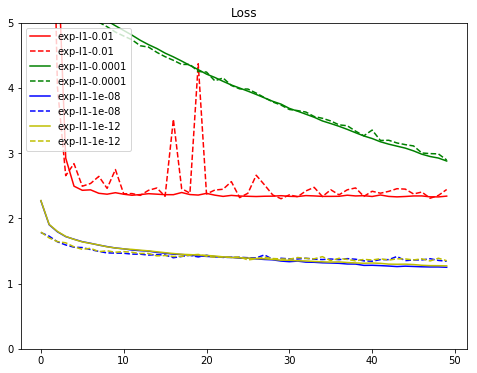

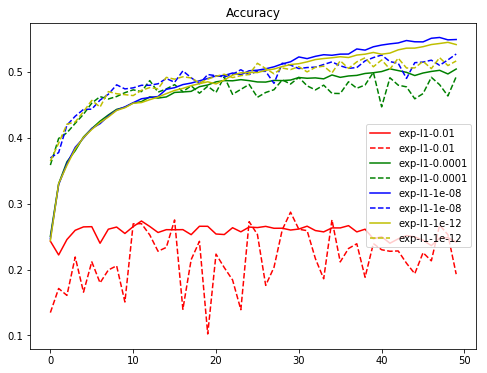

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
Plot results
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()